In [366]:
import pandas as pd
import numpy as np
import time

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

# Exploring data

In [ ]:
dataPath = 'nlp-getting-started/train.csv'
data = pd.read_csv(dataPath, index_col=0)

In [ ]:
data.info()

### Count

In [ ]:
data.count()

### Nan

In [ ]:
data.isna().sum()

In [ ]:
dataNonNull = data.dropna()

In [ ]:
print(f'{"Columns":20}: {"All":10} {"NonNull":10} {"%NonNull":10} {"Difference"}')
for idx, col in enumerate(data.columns):
    allValue = data.count()[idx]
    nonNullValue = dataNonNull.count()[idx]
    per = nonNullValue*100/allValue
    diff = allValue - nonNullValue
    print(f'{col:20}: {allValue} {nonNullValue:10} {np.round(per):10} {diff:10}')

In [ ]:
data['keyword'].fillna("", inplace=True)
data['location'].fillna("", inplace=True)

## Target

In [ ]:
columnName = 'target'

#----------------------
def getCategoricalColumn(value):
    if value == 1: return "Disaster"
    else: return "Not disaster"
    
CategoricalColumn = data[columnName].apply(getCategoricalColumn)
CategoricalColumn.name = 'catTarget'

df = pd.concat([data, CategoricalColumn], axis=1)
#----------------------

groups = []
for group, subset in df.groupby(by=CategoricalColumn.name):
    groups.append({
        CategoricalColumn.name: group,
        'Count': len(subset)
    })

lenData = data[columnName].count()

dataCategoricalQuality = pd.DataFrame(groups)

fig, ax = plt.subplots(figsize=(4, 4))

dataCategoricalQuality.plot.bar(x=CategoricalColumn.name, ax=ax)

for i in range(len(groups)):
    value = str(groups[i]['Count'])+': '+str(np.round(groups[i]['Count']*100/lenData))+'%'
    ax.text(i, groups[i]['Count'], value , horizontalalignment='center', 
            verticalalignment='bottom')

ax.set_ylim(0, lenData - lenData/5)

ax.set_xlabel('target')
ax.set_ylabel('Count')
ax.set_title('Sum: '+ str(lenData) )
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

### target vs keyword

In [ ]:
data['keyword'] = data['keyword'].str.replace('%20', ' ')

In [ ]:
columnNameA = 'target'
columnNameB = 'keyword'

crossTable = pd.crosstab(index=data[columnNameB],
                         columns=data[columnNameA],
                         margins=True)

crossTable.rename(columns={0 : 'Not disaster',1 : 'Disaster',}, inplace=True)

In [ ]:
print('Most frequent Keywords for Disaster')
crossTable.sort_values(by='Disaster', ascending=False).head(10)

In [ ]:
print('Most frequent Keywords for Not disaster')
crossTable.sort_values(by='Not disaster', ascending=False).head(10)

#### target vs keyword length (character)

In [ ]:
data['keywordLengthChar'] = data['keyword'].apply(len)

In [ ]:
columnNameA = 'target'
columnNameB = 'keywordLengthChar'

sns.boxplot(data=data, x=columnNameA, y=columnNameB)


plt.tight_layout()
plt.show()

In [ ]:
columnNameA = 'target'
columnNameB = 'keywordLengthChar'

g = sns.FacetGrid(data, col=columnNameA)
g.map(sns.histplot, columnNameB, bins=30)

plt.tight_layout()
plt.show()

We observe that keyword lengths are longer in Not Disaster than in Disaster

### target vs location

In [ ]:
columnNameA = 'target'
columnNameB = 'location'

crossTable = pd.crosstab(index=data[columnNameB],
                         columns=data[columnNameA],
                         margins=True)

crossTable.rename(columns={0 : 'Not disaster',1 : 'Disaster',}, inplace=True)

In [ ]:
print('Most frequent Locations for Disaster')
crossTable.sort_values(by='Disaster', ascending=False).head(10)

In [ ]:
print('Most frequent Locations for Not disaster')
crossTable.sort_values(by='Not disaster', ascending=False).head(10)

### target vs text

#### Number of character (including space)

In [ ]:
data['textLengthChar'] = data['text'].apply(len)

In [ ]:
columnName = 'textLengthChar'

ax = (data[columnName]).plot.box(figsize=(3, 4))
ax.set_ylabel(columnName)

plt.tight_layout()
plt.show()

In [ ]:
columnNameA = 'target'
columnNameB = 'textLengthChar'

g = sns.FacetGrid(data, col=columnNameA)
g.map(sns.histplot, columnNameB, bins=30)

plt.tight_layout()
plt.show()

We observe that text lengths are longer in Not Disaster than in Disaster

In [ ]:
columnNameA = 'target'
columnNameB = 'textLengthChar'

sns.boxplot(data=data, x=columnNameA, y=columnNameB)

plt.tight_layout()
plt.show()

#### Number of words

In [ ]:
def getWordTextLength(text):
    return len(text.split())
data['textLengthWord'] = data['text'].apply(getWordTextLength)

In [ ]:
columnName = 'textLengthWord'

ax = (data[columnName]).plot.box(figsize=(3, 4))
ax.set_ylabel(columnName)

plt.tight_layout()
plt.show()

In [ ]:
columnNameA = 'target'
columnNameB = 'textLengthWord'

g = sns.FacetGrid(data, col=columnNameA)
g.map(sns.histplot, columnNameB, bins=30)

plt.tight_layout()
plt.show()

We observe that number of words in text are longer in Not Disaster than in Disaster

In [ ]:
columnNameA = 'target'
columnNameB = 'textLengthWord'

sns.boxplot(data=data, x=columnNameA, y=columnNameB)

plt.tight_layout()
plt.show()

#### Link in text

In [ ]:
pattern = r'(https?://\S+)'
data['link']= data["text"].str.extract(pattern)
    
data['containLink'] = data['link'].notna()

In [ ]:
columnNameA = 'target'
columnNameB = 'containLink'

crossTable = pd.crosstab(index=data[columnNameB],
                         columns=data[columnNameA],
                         margins=True)

crossTable.rename(columns={0 : 'Not disaster',1 : 'Disaster',}, inplace=True)
crossTable.rename(index={False : 'No link',True : 'Link',}, inplace=True)

crossTable['Not disaster %'] = crossTable['Not disaster'] * 100 / crossTable['All']
crossTable['Disaster %'] = crossTable['Disaster'] * 100 / crossTable['All']

crossTable

We observe that there are more links in Disaster than Not Disaster.

# Processing data using PyPark

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

sc = SparkContext(master = "local", appName = "App").getOrCreate()
spark = SparkSession.builder.getOrCreate()

print(sc, sc.version, spark)

## Loading data

In [367]:
trainPath = 'nlp-getting-started/train.csv'
testPath = 'nlp-getting-started/test.csv'

trainData = spark.read.format('csv').options(header='true', inferSchema='true', multiLine=True).load(trainPath)
testData = spark.read.format('csv').options(header='true', inferSchema='true', multiLine=True).load(testPath)

print('Number of row in Training:', trainData.count())
print('Number of row in Test:    ', testData.count())

Number of row in Training: 7613
Number of row in Test:     3263


## Preprocessing

In [368]:
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, HasInputCols, HasOutputCols, Param, Params, TypeConverters
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable  
from pyspark.ml import Pipeline 
import pyspark.sql.functions as F
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, Word2Vec, StringIndexer,OneHotEncoder, VectorAssembler, RobustScaler

In [505]:
class FillNanTransformer(Transformer, HasInputCols, DefaultParamsReadable, DefaultParamsWritable):
    nanReplacement = Param(Params._dummy(), "nanReplacement", "nanReplacement", typeConverter=TypeConverters.toString)
    
    @keyword_only
    def __init__(self, inputCols=None, nanReplacement=None):
        super(FillNanTransformer, self).__init__()
        self._setDefault(nanReplacement="")
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCols=None, nanReplacement=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    
    def getNanReplacement(self):
        return self.getOrDefault(self.nanReplacement)
    
    def _transform(self, dataset):
        nanReplacement = self.getNanReplacement()
        dataset = dataset.na.fill(value=nanReplacement,subset=self.getInputCols())
        return dataset
    
class RemovePatternTransformer(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
    pattern = Param(Params._dummy(), "pattern", "pattern", typeConverter=TypeConverters.toString)
    
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None, pattern=None):
        super(RemovePatternTransformer, self).__init__()
        self._setDefault(pattern="")
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None, pattern=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def getPattern(self):
        return self.getOrDefault(self.pattern)
    
    def _transform(self, dataset):
        pattern = self.getPattern()
        dataset = dataset.withColumn(self.getOutputCol(), F.regexp_replace(F.col(self.getInputCol()), pattern, ""))
        return dataset
    
class CheckPatternTransformer(Transformer, HasInputCol, HasOutputCol):
    pattern = Param(Params._dummy(), "pattern", "pattern", typeConverter=TypeConverters.toString)
    
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None, pattern=None):
        super(CheckPatternTransformer, self).__init__()
        self._setDefault(pattern="")
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None, pattern=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    
    def getPattern(self):
        return self.getOrDefault(self.pattern)
    
    def _transform(self, dataset):
        pattern = self.getPattern()
        dataset = dataset.withColumn(self.getOutputCol(), F.when(F.col(self.getInputCol()).rlike(pattern),1.).otherwise(0.))
        return dataset
    
class GetLengthTransformer(Transformer, HasInputCols, HasOutputCols):
    @keyword_only
    def __init__(self, inputCols=None, outputCols=None):
        super(GetLengthTransformer, self).__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCols=None, outputCols=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    
    def _transform(self, dataset):
        for inputCol, outputCol in zip(self.getInputCols(), self.getOutputCols()):
            dataset = dataset.withColumn(outputCol, F.length(inputCol))
        return dataset
    
class ConcatenateTransformer(Transformer, HasInputCols, HasOutputCol):
    @keyword_only
    def __init__(self, inputCols=None, outputCol=None):
        super(ConcatenateTransformer, self).__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCols=None, outputCol=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def _transform(self, dataset):
        dataset = dataset.withColumn(self.getOutputCol(), F.col(self.getInputCols()[0]))
        for colName in self.getInputCols()[1:]:
            dataset = dataset.withColumn(self.getOutputCol(), 
                F.concat_ws('@', F.col(self.getOutputCol()), F.col(colName)))
        return dataset

In [513]:
fillNanTransformer = FillNanTransformer(inputCols=["keyword", "location"], nanReplacement="$")
textFillNanTransformer = FillNanTransformer(inputCols=["text"], nanReplacement="")

#---
removeUrlTransformer = RemovePatternTransformer(inputCol="text", outputCol="textNoUrl", pattern="(https?://\S+)")
regexTokenizer = RegexTokenizer(inputCol="textNoUrl", outputCol="textArrayWord", pattern="\\W")

stopWordsRemover = StopWordsRemover(inputCol="textArrayWord", outputCol="textNoSW")
word2Vec = Word2Vec(vectorSize=50, windowSize=10, minCount=0, inputCol="textNoSW", outputCol="textVec")

#---
keywordIndexer = StringIndexer(inputCol="keyword", outputCol="keywordIndex", handleInvalid="keep")
locationIndexer = StringIndexer(inputCol="location", outputCol="locationIndex", handleInvalid="keep")
checkUrlTransformer = CheckPatternTransformer(inputCol="text", outputCol="textIsContainedUrl", pattern="(https?://\S+)")

getLengthTransformer = GetLengthTransformer(inputCols=["keyword","textNoUrl"], outputCols=["keywordLen", "textNoUrlLen"])

oneHotEncoder = OneHotEncoder(inputCols=["keywordIndex", "locationIndex", "textIsContainedUrl"],
                              outputCols=["keywordVec", "locationVec", "textIsContainedUrlVec"],
                              handleInvalid="keep")

#---
concatStringTransformer = ConcatenateTransformer(inputCols=["keyword", "location", "textNoUrl"], outputCol="concatString")
concatStringRegexTokenizer = RegexTokenizer(inputCol="concatString", outputCol="concatStringArrayWord", pattern="\\W")
concatStringStopWordsRemover = StopWordsRemover(inputCol="concatStringArrayWord", outputCol="concatStringArrayWordNoSW")

concatStringWord2Vec = Word2Vec(vectorSize=50, windowSize=10, minCount=0, inputCol="concatStringArrayWord", outputCol="concatStringVec")
concatStringNoSWWord2Vec = Word2Vec(vectorSize=50, windowSize=10, minCount=0, inputCol="concatStringArrayWordNoSW", outputCol="concatStringNoSWVec")

#---

discreteFeaturesAssembler = VectorAssembler(inputCols=["keywordVec", "locationVec", "textIsContainedUrlVec",
                                                      "keywordLen", "textNoUrlLen"], 
                                            outputCol="discreteFeatures")

discreteAndTextFeaturesAssembler = VectorAssembler(inputCols=["discreteFeatures", "textVec"],
                                                   outputCol="discreteAndTextFeatures")

discreteFeaturesRobustScaler = RobustScaler(inputCol="discreteFeatures", outputCol="discreteFeaturesScale",
                                            withScaling=True, withCentering=True, lower=0.25, upper=0.75)

discreteAndTextFeaturesRobustScaler = RobustScaler(inputCol="discreteAndTextFeatures", outputCol="discreteAndTextFeaturesScale",
                                                   withScaling=True, withCentering=True, lower=0.25, upper=0.75)

In [514]:
preprocessingPipeline = Pipeline(stages=[fillNanTransformer, textFillNanTransformer,
                                         removeUrlTransformer, regexTokenizer, stopWordsRemover, word2Vec,
                                         keywordIndexer, locationIndexer, checkUrlTransformer, getLengthTransformer, oneHotEncoder,
                                         concatStringTransformer, concatStringRegexTokenizer, concatStringStopWordsRemover, 
                                         concatStringWord2Vec, concatStringNoSWWord2Vec,
                                         discreteFeaturesAssembler, 
                                         discreteAndTextFeaturesAssembler,
                                         discreteFeaturesRobustScaler, discreteAndTextFeaturesRobustScaler
                                        ])

## Training

In [515]:
preprocessingModel = preprocessingPipeline.fit(trainData)

trainDataPreprocessed = preprocessingModel.transform(trainData)
testDataPreprocessed = preprocessingModel.transform(testData)

In [516]:
trainSet, validSet = trainDataPreprocessed.randomSplit([0.9, 0.1], seed=12345)

### Pyspark algorithms

In [519]:
featuresCol = "concatStringNoSWVec"
labelCol = "target"

In [520]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, MultilayerPerceptronClassifier, LinearSVC

evaluator = BinaryClassificationEvaluator(labelCol=labelCol, rawPredictionCol="prediction", metricName="areaUnderROC")


algorithmList = {"LR":   LogisticRegression(featuresCol=featuresCol, labelCol=labelCol,regParam = 0.1, maxIter=50),
                 "DTC":  DecisionTreeClassifier(featuresCol=featuresCol, labelCol=labelCol, maxDepth=5),
                 "RFC":  RandomForestClassifier(featuresCol=featuresCol, labelCol=labelCol, maxDepth=5, numTrees=20),
                 "GBTC": GBTClassifier(featuresCol=featuresCol, labelCol=labelCol, maxIter=50, maxDepth=5, stepSize=0.1),
                 "MPC":  MultilayerPerceptronClassifier(featuresCol=featuresCol, labelCol=labelCol, maxIter=50, layers=[50, 10, 2]),
                 "LSVC": LinearSVC(featuresCol=featuresCol, labelCol=labelCol, maxIter=50, regParam=0.01)
                }

**We observe feature importance of categorical features**

In [521]:
discreteIndexFeaturesAssembler = VectorAssembler(inputCols=["keywordIndex", "locationIndex", "textIsContainedUrl",
                                                            "keywordLen", "textNoUrlLen"], 
                                                 outputCol="discreteIndexFeatures")

discreteIndexFeaturesRobustScaler = RobustScaler(inputCol="discreteIndexFeatures", outputCol="discreteIndexFeaturesScale",
                                            withScaling=True, withCentering=True, lower=0.25, upper=0.75)

checkSet = discreteIndexFeaturesAssembler.transform(trainSet)
checkSet = discreteIndexFeaturesRobustScaler.fit(checkSet).transform(checkSet)

featuresImportanceModel = RandomForestClassifier(featuresCol="discreteIndexFeaturesScale", 
                                                 labelCol=labelCol, maxDepth=5, numTrees=20).fit(checkSet)

for column in zip(discreteIndexFeaturesAssembler.getInputCols(), list(featuresImportanceModel.featureImportances)):
     print(f"{column[0]:20}: {column[1]}")

keywordIndex        : 0.19217661119128776
locationIndex       : 0.013495560468460904
textIsContainedUrl  : 0.3849196318014386
keywordLen          : 0.2706514888496067
textNoUrlLen        : 0.13875670768920598


**We observe predictions of validation set based on several feature sets:**
* "discreteFeaturesScale": "keywordIndex", "locationIndex", "keywordLength", "textNoLinkLength", "containLink"
* "discreteAndTextFeaturesScale": "discreteFeaturesScale" and "vecText"
* "vecText" only
* "concatStringVec": concatenate "keyword", "location" and "text" (not containing Urls), then apply Word2Vec
* "concatStringNoSWVec": concatenate "keyword", "location" and "text" (not containing Urls and stopwords), then apply Word2Vec

In [522]:
featuresCols = ["discreteFeaturesScale", "discreteAndTextFeaturesScale", 
                "textVec", "concatStringVec", "concatStringNoSWVec"]
algorithmName = "LR"
for param in featuresCols:
    startTime = time.time()
    algorithm = algorithmList[algorithmName].setFeaturesCol(param)
    prediction = algorithm.fit(trainSet).transform(validSet)
    score = evaluator.evaluate(prediction)
    print(f'Param {param}: {np.round(score,5)} in {np.round(time.time() - startTime, 3)}s')

Param discreteFeaturesScale: 0.62361 in 7.712s
Param discreteAndTextFeaturesScale: 0.67168 in 9.027s
Param textVec: 0.63521 in 7.704s
Param concatStringVec: 0.66073 in 7.864s
Param concatStringNoSWVec: 0.66723 in 7.839s


*We observe that "concatStringNoSWVec" (concatenating strings in "keyword", "location" and "text" without urls and stopwords) produces the best result, slightly better than "discreteAndTextFeaturesScale"*

**We combine two models: one based on categorical features and another based on text**

In [525]:
import sklearn.metrics as metrics

algorithmName = "LR"
featuresCols = ["discreteFeaturesScale", "textVec"]

predProbAll = []
trueLabel = np.array(validSet.select('target').collect()).squeeze()
for param in featuresCols:
    startTime = time.time()
    algorithm = algorithmList[algorithmName].setFeaturesCol(param)
    
    prediction = algorithm.fit(trainSet).transform(validSet)
    
    predProb = np.array(prediction.select('probability').collect()).squeeze()
    
    score = evaluator.evaluate(prediction)
    print(f"Param {param:2}: {np.round(score,5)}")
    
    predProbAll.append(predProb)
        
print("------------")
for weight in np.arange(0.0, 1.1, 0.1):
    predProb = weight*predProbAll[0] + (1.- weight)*predProbAll[1]
    predLabel = np.array([1 if x[1] >= 0.5 else 0 for x in (predProb)])
    score = metrics.roc_auc_score(trueLabel, predLabel)
    print(f"{str(weight)[:4]:5} {str((1.- weight))[:4]:5} {np.round(score,5)}")

Param discreteFeaturesScale: 0.62361
Param textVec: 0.63521
------------
0.0   1.0   0.63521
0.1   0.9   0.63702
0.2   0.8   0.64126
0.30  0.7   0.65187
0.4   0.6   0.6567
0.5   0.5   0.65061
0.60  0.39  0.66211
0.70  0.29  0.66631
0.8   0.19  0.65893
0.9   0.09  0.6364
1.0   0.0   0.62361


*The combination \[0.1, 0.3] gives the highest score, but it does not outperform "concatStringNoSWVec"*

In [ ]:
import sklearn.metrics as metrics

trueLabel = np.array(validSet.select('target').collect()).squeeze()
predLabel = np.array(prediction.select('prediction').collect()).squeeze()
predProb = np.array(prediction.select('probability').collect()).squeeze()

print(metrics.classification_report(trueLabel, predLabel))

### Other algorithms

#### Write data

In [490]:
from os import walk
import re

def getCSVFromPysparkPath(path):
    filenames = next(walk(path), (None, None, []))[2]
    for filename in filenames:
        if re.search('^part', filename):
            return path+'/'+filename

In [483]:
featuresCol = "concatStringNoSWVec"
labelCol = "target"

from pyspark.ml.functions import vector_to_array

(trainSet.withColumn("feature", vector_to_array(featuresCol)))\
.select(["target"]+ [F.col("feature")[i] for i in range(5)]).write.mode('overwrite').csv('trainCSV')

(validSet.withColumn("feature", vector_to_array(featuresCol)))\
.select([F.col("feature")[i] for i in range(5)]).write.mode('overwrite').csv('validCSV')

trainPath = getCSVFromPysparkPath("trainCSV")
validPath = getCSVFromPysparkPath("validCSV")

In [484]:
(testDataPreprocessed.withColumn("feature", vector_to_array(featuresCol)))\
.select([F.col("feature")[i] for i in range(50)]).write.mode('overwrite').csv('testCSV')

testPath = getCSVFromPysparkPath("testCSV")

#### Lightgbm

In [485]:
import lightgbm as lgb

In [486]:
trainSetLgb = lgb.Dataset(trainPath)
#validSetLgb = lgb.Dataset(validPath, reference=trainSetLgb)

In [487]:
param = {'num_leaves':60, 
         'objective': 'binary',
         'metric': 'auc',
         'learning_rate': 0.01,
         'boosting': 'dart',
         'label_column': 0,
        }

num_round=500
modelLgb = lgb.train(param,trainSetLgb, num_round)

In [488]:
import sklearn.metrics as metrics

predProbModel = modelLgb.predict(validPath, num_iteration=bst.best_iteration)

trueLabel = np.array(validSet.select('target').collect()).squeeze()
predLabel = np.array([1 if x >= 0.5 else 0 for x in predProbModel])
predProb = np.array([[1. - x, x] for x in predProbModel])

print(metrics.roc_auc_score(trueLabel, predLabel))

0.6986570225152711


Score: 0.7103956764405998


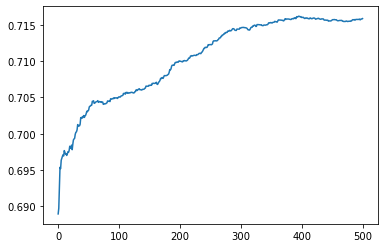

In [489]:
cvLgb = lgb.cv(param, trainSetLgb, 500, nfold=3)["auc-mean"]

fig = plt.figure()
ax = plt.axes()

ax.plot(cvLgb)
print('Score:', np.mean(cvLgb))

## Predict and write file

#### For Pyspark

In [ ]:
predictionTest = algorithm.fit(trainDataPreprocessed).transform(testDataPreprocessed)

In [ ]:
predLabelTest = np.array(predictionTest.select('prediction').collect()).squeeze()

#### For other algorithms

##### LightGBM

In [493]:
predictionTest = modelLgb.predict(testPath, num_iteration=bst.best_iteration)

In [494]:
predLabelTest = np.array([1 if x >= 0.5 else 0 for x in predictionTest])

#### Upload to kaggle

In [495]:
submission = pd.read_csv('nlp-getting-started/sample_submission.csv')
submission['target'] = submission['target'] + predLabelTest.astype(int)
submission.to_csv('submission.csv', index=False)

In [496]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "LightGbm-Concat"

100%|██████████████████████████████████████| 22.2k/22.2k [00:04<00:00, 4.82kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets